<a href="https://colab.research.google.com/github/DesiPilla/demographics-voterid-turnout/blob/master/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pip install geopandas
import geopandas as gp

from statsmodels.stats.weightstats import ztest
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics.pairwise import euclidean_distances

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Datasets

In [0]:
# Load full datasets (only one nan row)
data = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data.shp').dropna()
data_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_mainland.shp').dropna()
data_no_ak = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_no_ak.shp').dropna()

In [0]:
# Load demographic datasets
demgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo.shp')
demgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo_mainland.shp')

# Load voter ID datasets
votgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo.shp')
votgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo_mainland.shp')

# Load turnout datasets
turngeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo.shp')
turngeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo_mainland.shp')

# Non-Machine Learning Analysis

## Classify "disadvantaged" counties

We will weight certain features to classify counties as either “disadvantaged” or “non-disadvantaged”.

The four features being used to create this "disadvantage index" are the following:
 * `1 - MedieanHous`: the smaller the median househole income, the more disadvantaged the county is.
 * `1 - CollegeDeg`: the smaller the percentage of residents with a college degree, the more disadvantaged the county is.
 * `MedianAge`: the larger the median age, the more disadvantaged the county is.
 * `not_white`: the larger the minority population, the more disadvantaged the county is.

In [32]:
cols = ['MedianHous', 'CollegeDeg', 'MedianAge', 'not_white']

# Get county fips and geometry for future use
county_fip = data_no_ak.county_fip
geometry = data_no_ak.geometry

# Get features and standardize them
feat = data_no_ak[cols]
feat_st = (feat - feat.mean()) / feat.std()

# Orient the features so lower values correspond to more disadvantage
feat_st['MedianHous'] = 1 - feat_st['MedianHous']
feat_st['CollegeDeg'] = 1 - feat_st['CollegeDeg']

# sum across the features and weight equally
data_no_ak['disadvantage_index'] = feat_st.sum(axis=1) / 4
data_no_ak['disadvantage_index'] -= data_no_ak.disadvantage_index.min()
data_no_ak['disadvantage_index'] /= data_no_ak.disadvantage_index.max()
data_no_ak['disadvantaged'] = data_no_ak['disadvantage_index'] > data_no_ak['disadvantage_index'].quantile(0.85)
data_no_ak[['county_fip'] + cols + ['disadvantage_index', 'disadvantaged']].head()

,county_fip,MedianHous,CollegeDeg,MedianAge,not_white,disadvantage_index,disadvantaged
0,31039,50013.0,0.383511,43.6,0.039987,0.578743,False
1,31109,51830.0,0.517659,32.9,0.126604,0.416972,False
2,31129,40488.0,0.337133,49.2,0.020269,0.695995,False
3,31101,41781.0,0.360804,49.1,0.035232,0.681118,False
4,31137,50404.0,0.380159,42.0,0.029188,0.559238,False


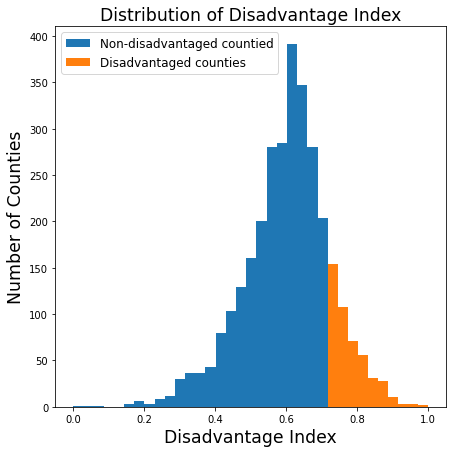

In [33]:
fig, ax = plt.subplots(figsize=(7, 7));
ax.hist(data_no_ak[~data_no_ak.disadvantaged].disadvantage_index, bins=25, label='Non-disadvantaged countied')
ax.hist(data_no_ak[data_no_ak.disadvantaged].disadvantage_index, bins=10, label='Disadvantaged counties')
ax.set_title('Distribution of Disadvantage Index', fontsize='xx-large')
ax.set_ylabel('Number of Counties', fontsize='xx-large')
ax.set_xlabel('Disadvantage Index', fontsize='xx-large')
ax.legend(fontsize='large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_hist.png', clobber=True)
fig.show();

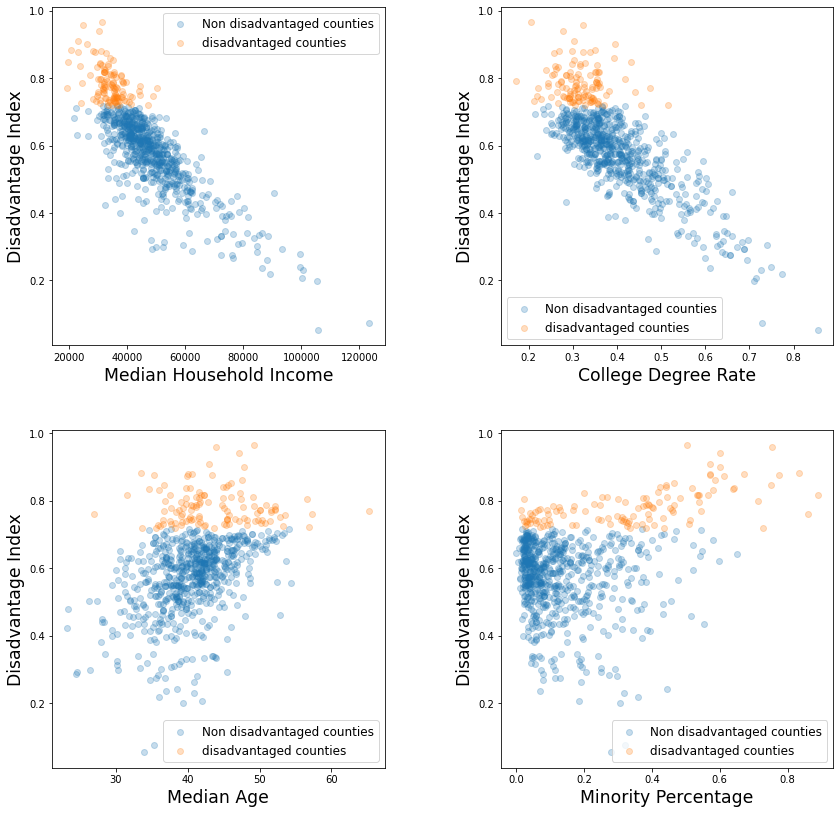

In [34]:
feat_names = ['Median Household Income', 'College Degree Rate', 'Median Age', 'Minority Percentage']
feat_labels = ['Median\nHousehold\nIncome', 'College\nDegree\nRate', 'Median Age', 'Minority\nPercentage']

r, c = 2, 2
fig, ax = plt.subplots(r, c, figsize=(7*c, 7*r))
for i in range(np.prod(ax.shape)):

    # Get index of counties in the bottom 25th percentile
    idx = data_no_ak.disadvantaged
    step = 4
    alpha = 0.25

    # Plot the counties, colored by their percentile
    ax[i // c][i % c].scatter(feat.values[~idx, i][::step], data_no_ak['disadvantage_index'][~idx][::step], alpha=alpha, label='Non disadvantaged counties')
    ax[i // c][i % c].scatter(feat.values[idx, i][::step], data_no_ak['disadvantage_index'][idx][::step], alpha=alpha, label='disadvantaged counties')

    ax[i // c][i % c].set_ylabel('Disadvantage Index', fontsize='xx-large')
    ax[i // c][i % c].set_xlabel(feat_names[i], fontsize='xx-large')
    ax[i // c][i % c].legend(fontsize='large')

fig.subplots_adjust(hspace=0.25, wspace=0.35)
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_correlations.png', clobber=True)
fig.show();

## z-tests

In [0]:
def make_bins(xcol, ycol, n_bins=4):
    bins, means, stds, labels = [], [], [], []

    for i in range(n_bins):
        # Get values in the i-th bin
        bot = i / n_bins
        top = (i + 1) / n_bins
        labels.append('{0:.0%} - {1:.0%}'.format(bot, top))

        idx = (data_no_ak[xcol] > data_no_ak[xcol].quantile(bot)) & (data_no_ak[xcol] < data_no_ak[xcol].quantile(top))

        # Get bin data
        bins.append(data_no_ak[idx][ycol].values)
        means.append(np.mean(bins[i]))
        stds.append(np.std(bins[i]))

    return np.array(bins), means, stds, labels

def split_by(split_col, ycol):
    bins, means, stds, labels = [], [], [], []

    for i, val in enumerate(data_no_ak[split_col].unique()):
        # Get values with the label i
        labels.append('{0:.0f}'.format(i+1))
        bins.append(data_no_ak[data_no_ak[split_col] == val][ycol].values)
        means.append(np.mean(bins[i]))
        stds.append(np.std(bins[i]))

    return np.array(bins), means, stds, labels

def plot_split(xcol, ycol='turnout', n_bins=4, xlabel=None, fig=None, ax=None):
    binning = True
    if not n_bins:
        bins, means, stds, labels = split_by(xcol, ycol)
        n_bins = len(bins)
        binning = False
    else:    
        bins, means, stds, labels = make_bins(xcol, ycol, n_bins)

    # Plot the performance
    if not fig:
        fig, ax = plt.subplots(figsize=(2*n_bins, 5))

    # Make the plot
    ax.bar(np.arange(len(means)), means, edgecolor='white')
    ax.errorbar(np.arange(len(means)), means, yerr=stds, fmt=',k', capsize=10)
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels, fontsize='large')

    if not binning:
        ax.set_xlabel(xlabel, fontsize='x-large')    
    else:
        ax.set_xlabel('Percentile Bins', fontsize='x-large')

    if ycol == 'turnout':
        ax.set_ylabel('Turnout Rate', fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Turnout Rate by {0}'.format(xlabel), fontsize='xx-large')
    elif ycol =='VoterIDLaw':
        ax.set_ylabel('Average Voter ID Law', fontsize='x-large')
        ax.set_title('Voter ID Law Strictness by {0}'.format(xlabel), fontsize='xx-large')

    return fig

def print_ztest(sample1, sample2, target='turnout rate', alpha=0.05):
    dis_std = np.std(dis)
    non_dis_std = np.std(non_dis)

    z_statistic, pval = ztest(sample1,sample2)

    print('Null hypothesis: The two samlpes have the \033[1msame mean', target)
    print("\n\033[0mdisadvantaged mean value: {0:.4f}".format(np.mean(sample1)))
    print("non-disadvantaged mean value: {0:.4f}".format(np.mean(sample2)))

    print("\ndisadvantaged std value: {0:.4f}".format(np.std(sample1)))
    print("non-disadvantaged std value: {0:.4f}".format(np.std(sample2)))

    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, pval))
    if pval < alpha:
        print("we reject null hypothesis")
    else:
        print("we accept null hypothesis")
    print('\033[0m\n\n')

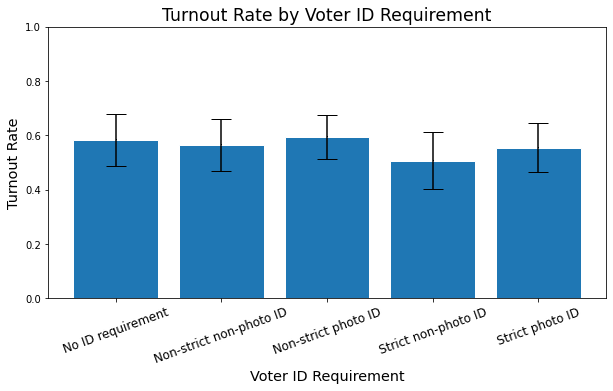

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = plot_split('VoterIDL_1', 'turnout', n_bins=None, xlabel='Voter ID Requirement', fig=fig, ax=ax)
ax.set_xticklabels(data_no_ak.VoterIDL_1.unique(), rotation=20)
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/idlaw_conditional_turnouts.png', clobber=True)

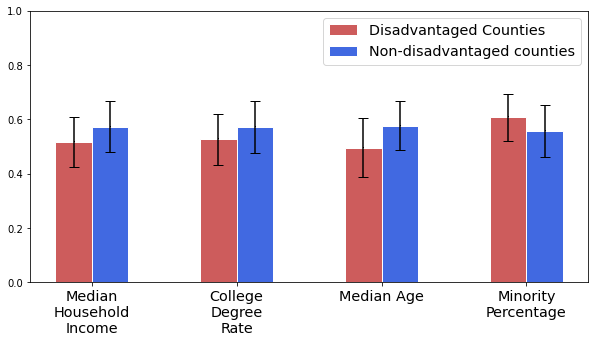

In [37]:
dis_means, non_dis_means = [], []
dis_stds, non_dis_stds = [], []
pvals = []

for c in cols:
    idx = data_no_ak[c] < data_no_ak[c].quantile(0.15)

    # Split the data into disadvantaged and non-disadvantaged
    dis = data_no_ak[idx].turnout.values
    non_dis = data_no_ak[~idx].turnout.values

    # Find the mean of each group
    dis_mean = np.mean(dis)
    dis_means.append(dis_mean)
    non_dis_mean = np.mean(non_dis)
    non_dis_means.append(non_dis_mean)

    # Fint the standard deviation of each group
    dis_std = np.std(dis)
    dis_stds.append(dis_std)
    non_dis_std = np.std(non_dis)
    non_dis_stds.append(non_dis_std)

    # Conduct a z-test on the two groups
    z_statistic, pval = ztest(dis,non_dis)
    pvals.append(pval)

# Set position of bar on X axis
barWidth = 0.25
x1 = np.arange(len(dis_means))
x2 = [x + barWidth for x in x1]

# Plot the performance
fig, ax = plt.subplots(figsize=(10, 5))

# Make the plot
ax.bar(x1, dis_means, color='indianred', width=barWidth, edgecolor='white', label='Disadvantaged Counties')
ax.errorbar(x1, dis_means, yerr=dis_stds, fmt=',k', capsize=5)
ax.bar(x2, non_dis_means, color='royalblue', width=barWidth, edgecolor='white', label='Non-disadvantaged counties')
ax.errorbar(x2, non_dis_means, yerr=non_dis_stds, fmt=',k', capsize=5)
ax.set_xticks((x1 + x2)/2)
ax.set_xticklabels(feat_labels, fontsize='x-large', rotation=0)
ax.set_ylim(0, 1)
ax.set_title('', fontsize='x-large')
ax.legend(fontsize='x-large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/disadvantaged_conditional_turnouts.png', clobber=True)
fig.show();

In [38]:
print_ztest(dis, non_dis)

Null hypothesis: The two samlpes have the same mean turnout rate

disadvantaged mean value: 0.6071
non-disadvantaged mean value: 0.5573

disadvantaged std value: 0.0850
non-disadvantaged std value: 0.0969

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis





## Conditional turnout rates and ANOVA

In [0]:
def print_anova(xcol, ycol='turnout', n_bins=4, target='turnout rate', alpha=0.05):
    if not n_bins:
        bins, means, stds, labels = split_by(xcol, ycol)
    else:    
        bins, means, stds, labels = make_bins(xcol, ycol, n_bins)
        
    F, p = f_oneway(*bins)

    print('Null hypothesis: The samlpes have the \033[1msame mean', target, '\033[0m')
    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, p))
    if p < alpha:
        print("we reject null hypothesis")
    else:
        print("we accept null hypothesis")
    print('\033[0m')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 2.42e-90
we reject null hypothesis



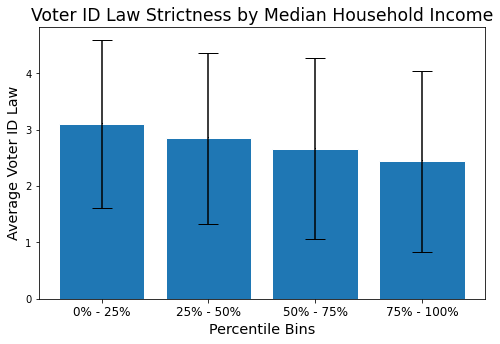

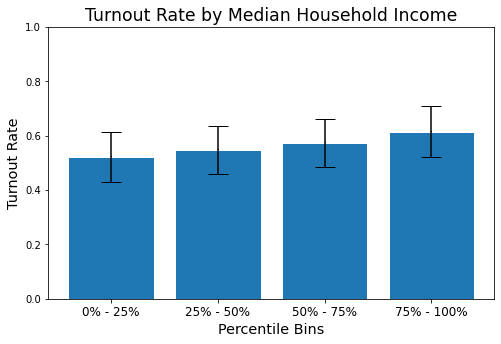

In [40]:
fig = plot_split('MedianHous', 'VoterIDLaw', 4, 'Median Household Income');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianhous_conditional_idlaw.png', clobber=True)

fig = plot_split('MedianHous', 'turnout', 4, 'Median Household Income');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianhous_conditional_turnouts.png', clobber=True)

print_anova('MedianHous', 'turnout', n_bins=4, target='Median Household Income')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 1.88e-46
we reject null hypothesis



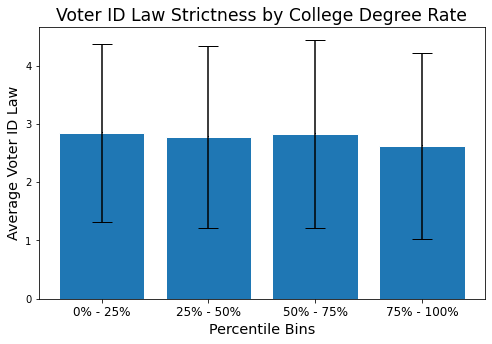

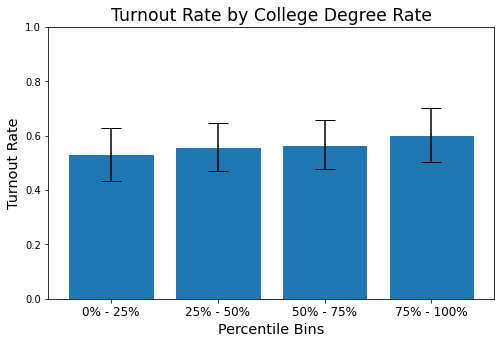

In [41]:
fig = plot_split('CollegeDeg', 'VoterIDLaw', 4, 'College Degree Rate');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/collegedeg_conditional_idlaw.png', clobber=True)

fig = plot_split('CollegeDeg', 'turnout', 4, 'College Degree Rate');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/collegedeg_conditional_turnouts.png', clobber=True)

print_anova('CollegeDeg', 'turnout', n_bins=4, target='Median Household Income')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 6.90e-90
we reject null hypothesis



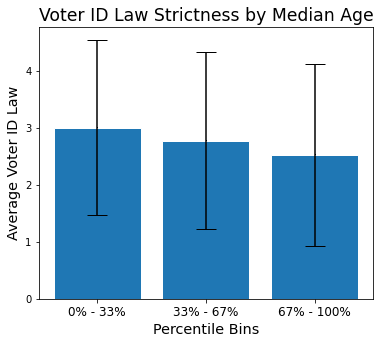

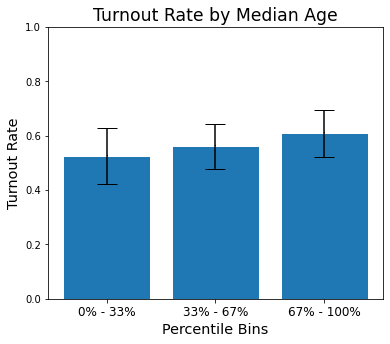

In [42]:
fig = plot_split('MedianAge', 'VoterIDLaw', 3, 'Median Age');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianage_conditional_idlaw.png', clobber=True)

fig = plot_split('MedianAge', 'turnout', 3, 'Median Age');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianage_conditional_turnouts.png', clobber=True)

print_anova('MedianAge', 'turnout', n_bins=3, target='Median Household Income')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 7.29e-72
we reject null hypothesis



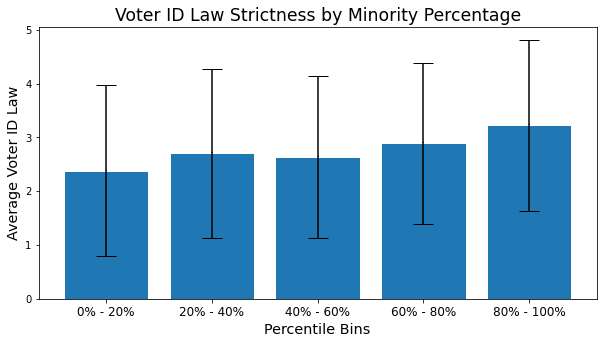

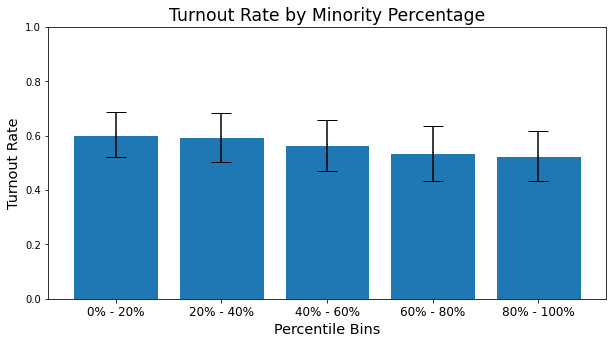

In [43]:
fig = plot_split('not_white', 'VoterIDLaw', 5, 'Minority Percentage');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/minority_conditional_idlaw.png', clobber=True)

fig = plot_split('not_white', 'turnout', 5, 'Minority Percentage');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/minority_conditional_turnouts.png', clobber=True)

print_anova('not_white', 'turnout', n_bins=5, target='Median Household Income')

# Machine Learning Analysis

## Plotting functions

In [0]:
def geoplot(gdf, col, cmap="viridis", title="", legend_title="", cbar_label="", cbar_fmt='%.2f', cbar=False, showfig=True, fig=None, ax=None):
    """This function plots a continuous variable in a geopandas dataframe with 
    an appropriately sized colorbar adjacent to it.

    Arguments
    ---------------------------------------------------------------------------
    gdf: this is the geopandas dataframe
    col: this ithe column to be plotted
    cmap: this is the colormap to be used in the plot
    title: this is the title that is to be given to the plot
    legend_title: this is the title to be given to the colorbar
    cbar_fmt: this it the number formatting to be applied to the colorbar
    cbar: {False, 'limit', 'normed', (tuple)}
        -False: the colorbar will have a min and max value equal to the min and max of the data
        -'limit': the colorbar will have a min and max value equal to the 98th and 2nd percentiles of the data
        -'normed': the colorbar will be limited to the range [0, 1]
        -(vmin, vmax): explicit values for vmin and vmax
    """

    # Make figure, axis, and plot it
    if not fig:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Add colorbar of appropriate size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    if cbar==False:
        min_lim, max_lim = min(gdf[col]), max(gdf[col])
    elif cbar=="limit":
        tot = len(gdf[col])
        min_lim, max_lim = list(gdf[col].sort_values())[int(tot*0.02)], list(gdf[col].sort_values())[int(tot*0.98)]
    elif cbar=="normed":
        min_lim, max_lim = 0, 1
    else:
        min_lim, max_lim = cbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_lim, vmax=max_lim))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, format=cbar_fmt)
    cbar.ax.set_title(legend_title)
    cbar.set_label(cbar_label, labelpad=20, rotation=270, fontsize='large')

    # Plot the data
    gdf.plot(col, ax=ax, cmap=cmap, vmin=min_lim, vmax=max_lim);

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Label
    ax.set_title(title, fontsize='xx-large')
    if showfig:
        fig.show();
        fig.tight_layout();

    return fig, ax

In [0]:
def geoplot_categorical(gdf, col, title="", legend_kwds={'loc':'lower left', 'bbox_to_anchor':(0, 0), 'fontsize':'small'}, show_legend=True, fig=None, ax=None):
    """This function plots a categorical variable in a geopandas dataframe with 
    an appropriately sized colorbar adjacent to it.

    Arguments
    ---------------------------------------------------------------------------
    gdf: this is the geopandas dataframe
    col: this ithe column to be plotted
    title: this is the title that is to be given to the plot
    legend_kwds: these are matplotlib legend keywords to describe the legend
        -'loc'
        -'bbox_to_anchor'
        -'fontsize'
    """
    # Make figure, axis, and plot it
    if not fig:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    gdf.plot(col, ax=ax, categorical=True, legend=True, cmap='viridis', legend_kwds=legend_kwds);

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Convert labels to integers if possible
    for lbl in ax.get_legend().get_texts():
        label_text = lbl.get_text()
        try:
            lbl.set_text(int(float(label_text)))
        except:
            pass
    if not show_legend:
        ax.get_legend().remove()

    # Label
    ax.set_title(title, fontsize='xx-large')
    fig.tight_layout()
    fig.show();

    return fig, ax

## Data Preparation

In [0]:
feat = data_no_ak.drop(columns=['county_fip', 'turnout', 'county_nam', 'state_abbr', 'VEP', 'STATEFP', 'ElectoralV', 'VoterIDL_1', 'geometry', 'disadvantage_index', 'disadvantaged'])
feat_st = (feat - feat.mean()) / feat.std()

target = data_no_ak.turnout
target_st = (target - target.mean()) / target.std()

X_train, X_test, y_train, y_test = train_test_split(feat_st, target_st, test_size=0.25, random_state=667)

In [47]:
# Get the voting-eligible persons in each county and state for weighting
vep = np.array(data_no_ak.VEP).reshape(-1, 1)
state_vep = data_no_ak[['state_abbr', 'VEP']].groupby('state_abbr').mean().values

# Weight the features by VEP
feat_wt = np.multiply(vep, feat)

# Group counties by state
feat_wt['state'] = data_no_ak.state_abbr

# Standardize by VEP and normalize data
feat_states = feat_wt.groupby('state').mean() / state_vep
feat_states_st = (feat_states - feat_states.mean()) / feat_states.std()

feat_states.head()

,MedianHous,CollegeDeg,34_younger,35_to_59,60_older,MedianAge,not_white,unemployed,VoterIDLaw
state,,,,,,,,,
AL,44500.447866,0.427330,0.295730,0.430763,0.273508,38.431364,0.310882,0.060625,3.0
AR,41878.943767,0.412084,0.298390,0.422407,0.279203,38.031863,0.219146,0.035405,2.0
AZ,50351.539976,0.441120,0.308040,0.413452,0.278509,37.161379,0.214346,0.052951,4.0
CA,63447.423815,0.503290,0.327991,0.438212,0.233796,35.927705,0.382703,0.053449,1.0
CO,61635.303653,0.541660,0.321136,0.442896,0.235968,36.611010,0.157334,0.031028,2.0


## Clustering at the County Level (Desi)

### Use the elbow method to determine an appropriate number of clusters to use

In [0]:
clust_cnty_st = feat_st.drop(columns=['VoterIDLaw'])

inertias = []
max_clust = 20
for n in range(1, max_clust+1):
    clust = KMeans(n_clusters=n, random_state=667).fit(clust_cnty_st)
    inertias.append(clust.inertia_)

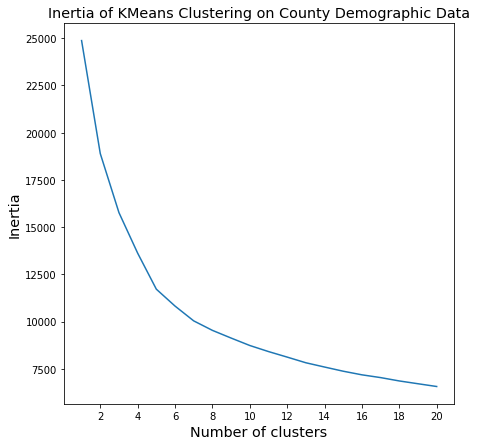

In [90]:
fig , ax = plt.subplots(figsize=(7, 7))
ax.plot(range(1, max_clust+1), inertias)
ax.set_title("Inertia of KMeans Clustering on County Demographic Data", fontsize='x-large')
ax.set_ylabel("Inertia", fontsize='x-large')
ax.set_xlabel("Number of clusters", fontsize='x-large')
ax.set_xticks(range(2, max_clust+1, 2))
ax.set_xticklabels(range(2, max_clust+1, 2));

**Figure:** By observing the decreasing inertia of the clusters, it is not explicitly clear that a certain *k* is optimal. The choice $k=5$ is an appropriate choice. This is also equal to the number of Voter ID Law categories that exist in state legistatures.

### Plot each cluster

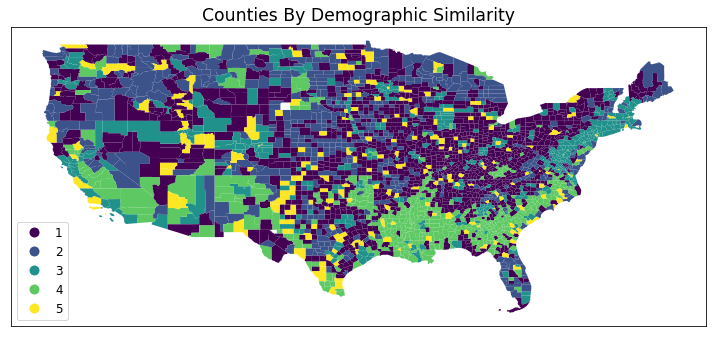

In [50]:
clust_cnty_st = feat_st.drop(columns=['VoterIDLaw'])

clust_1 = KMeans(n_clusters=5, random_state=667).fit(clust_cnty_st)

data_no_ak['cluster'] = clust_1.predict(clust_cnty_st)
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster.astype(int) + 1

fig, ax = geoplot_categorical(data_mainland, 'cluster', title="Counties By Demographic Similarity", legend_kwds={'loc':'lower left','fontsize':'large'})
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/clusters.png');

**Figure:** This figure shows a plot of all counties, categorized by their demographic similarity. Counties were split into 5 clusters, where they were grouped by the similarity in their demographic makeup.

In [51]:
print('The inertia of this clustering is {0:.0f}.'.format(clust_1.inertia_))

The inertia of this clustering is 11712.


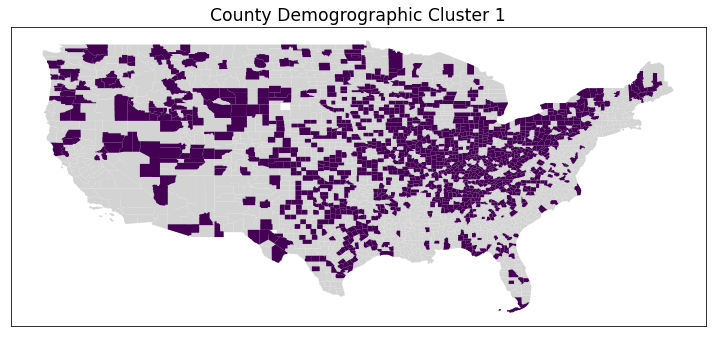

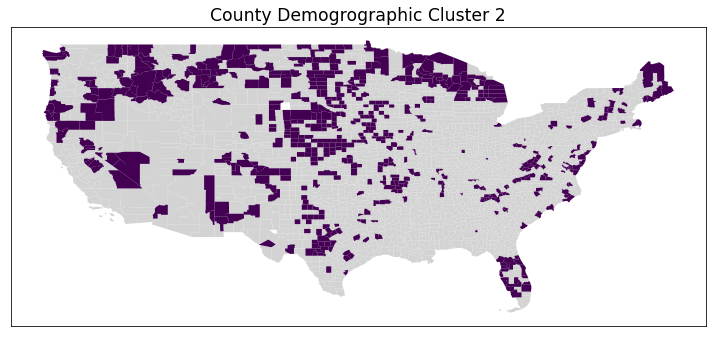

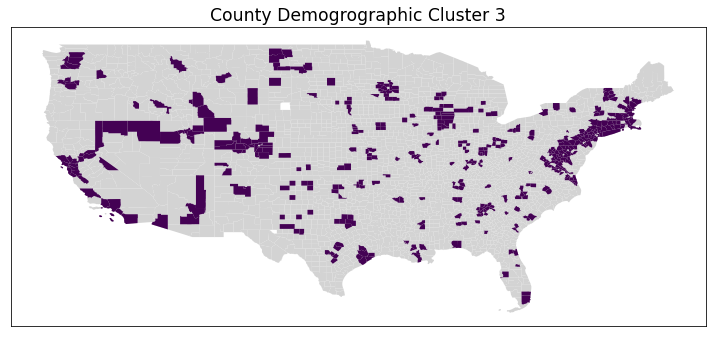

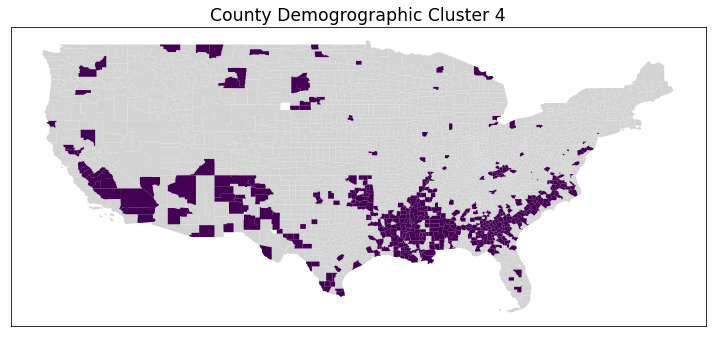

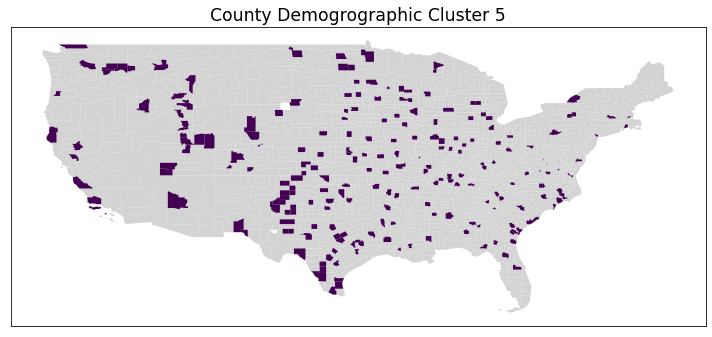

In [52]:
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster

for i in range(clust_1.n_clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_mainland.plot(color='lightgray', ax=ax)
    fig, ax = geoplot_categorical(data_mainland[data_mainland['cluster'] == i], 'cluster', title="County Demogrographic Cluster {0}".format(i+1), fig=fig, ax=ax, show_legend=False)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/cluter_{0}.png'.format(i+1))

**Figure:** The above figures show each demographic cluster plotted exclusively. This is helpful to distinguish where similar counties are located.Cluster 1 is widespread across America, with most of the counties in the Midwest (Ohio, Michigan, Wisconsin, Iowa, Missouri) falling into this group. Cluster 2 is more sporadic, yet contains many of the northern-most counties, as well as some in the central region of the United States and in Florida. Cluster 3 is most heavily dominated by counties along the Northeastern seaboard, as well as the urban population centers on the west coast. Cluster 4 is overwhelmingly represented by counties in the southern half of the United States. Lastly, cluster 5 is very sporadic and not unique to any distinguishable geographic region.

### Plot the Voter ID Laws of each cluster

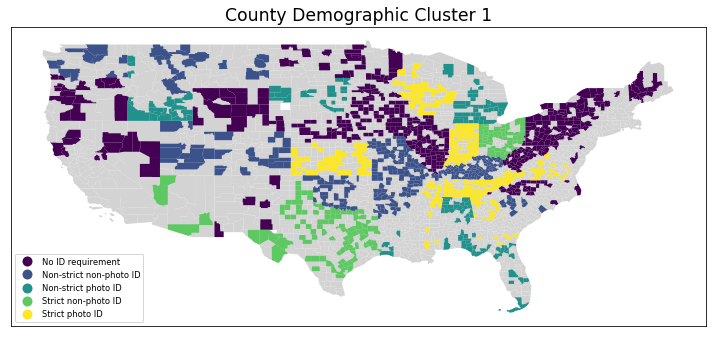

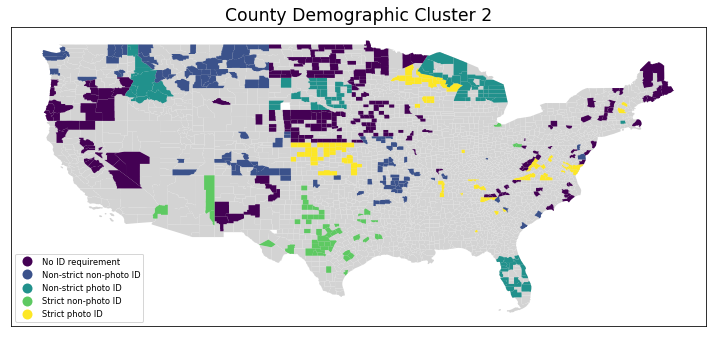

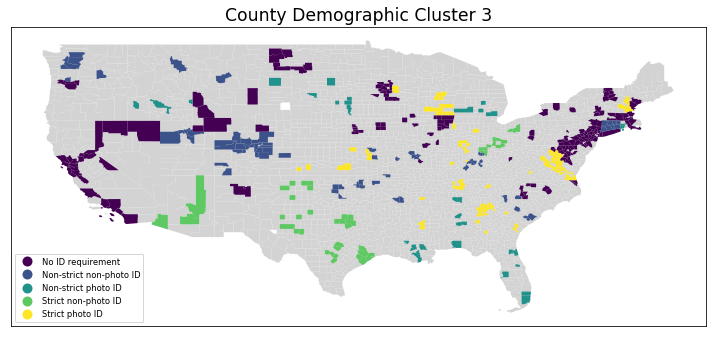

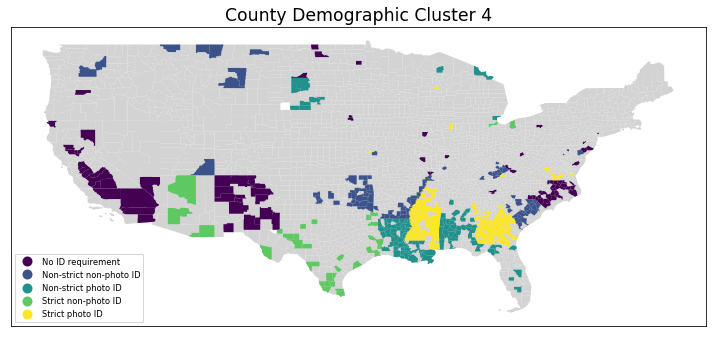

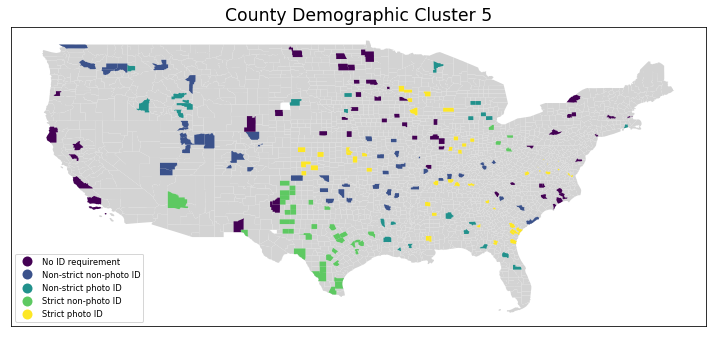

In [53]:
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster

for i in range(clust_1.n_clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_mainland.plot(color='lightgray', ax=ax)
    geoplot_categorical(data_mainland[data_mainland['cluster'] == i], 'VoterIDL_1', title="County Demographic Cluster {0}".format(i+1), fig=fig, ax=ax)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/idlaw_cluter_{0}.png'.format(i+1))

**Figure:** The figures above display the Voter ID Requirements of the counties in each deomgraphic cluster. Each Voter ID law is well represented among all 5 clusters. This is likely because Voter ID laws are established at the state level, while the clusters were formed at the county level. Demographics are not homogeneous across all counties in a state, leading to there being at least a couple of counties from each demographic cluster in most states.

Null hypothesis: The samlpes have the same mean voter ID strictness 

p-value for 0.0500 significance: 2.93e-15
we reject null hypothesis



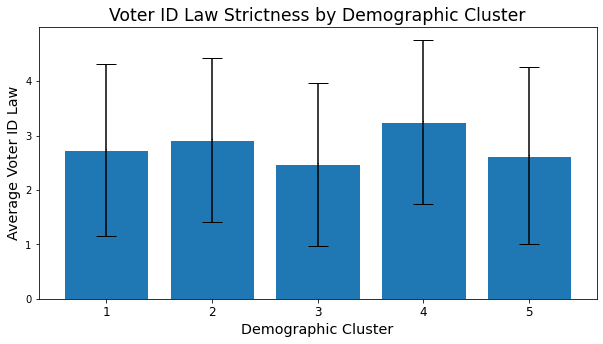

In [54]:
fig = plot_split('cluster', 'VoterIDLaw', n_bins=False, xlabel='Demographic Cluster')
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/idlaw_anova.png', clobber=True)

print_anova('cluster', 'VoterIDLaw', n_bins=False, target="voter ID strictness")

### Plot the Voter Turnout of each cluster

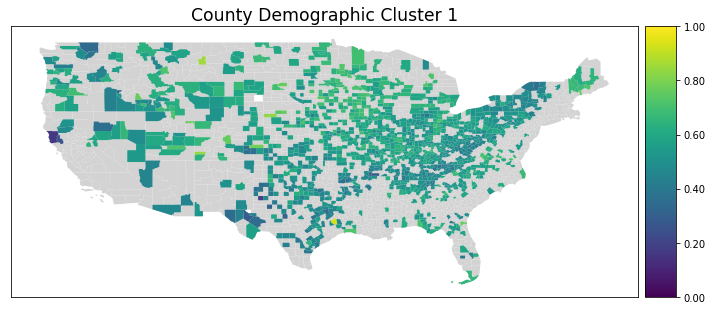

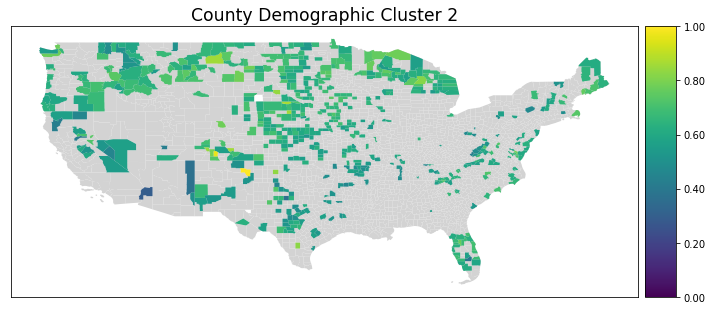

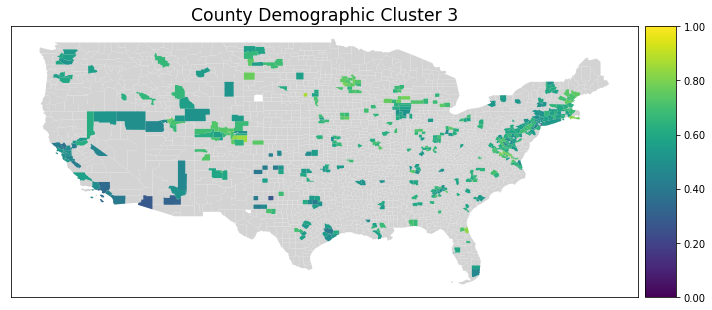

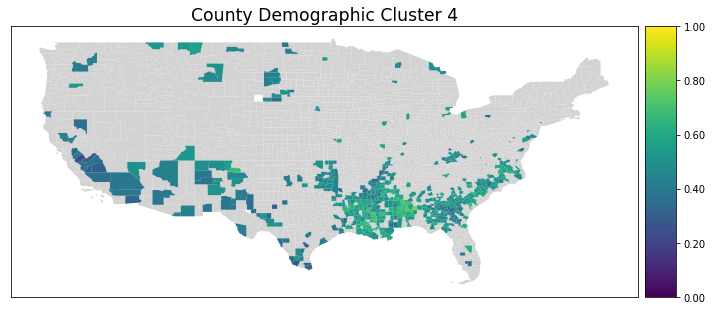

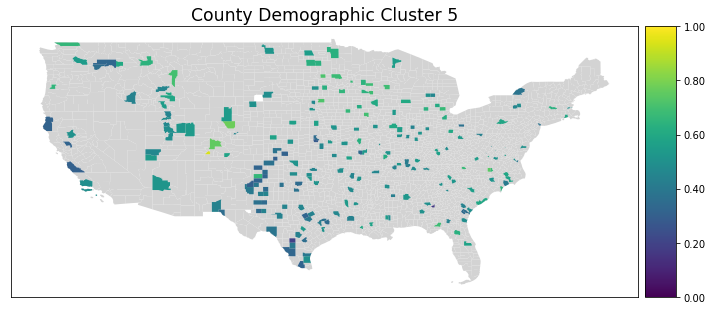

In [55]:
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster

for i in range(clust_1.n_clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_mainland.plot(color='lightgray', ax=ax)
    geoplot(data_mainland[data_mainland['cluster'] == i], 'turnout', title="County Demographic Cluster {0}".format(i+1), cbar="normed", fig=fig, ax=ax)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/turnout_cluter_{0}.png'.format(i+1))

**Figure:** From these figures, it is not very clear if there is a relationship between the demographic clusters and voter turnout.

Null hypothesis: The samlpes have the same mean turnout rate 

p-value for 0.0500 significance: 4.19e-149
we reject null hypothesis



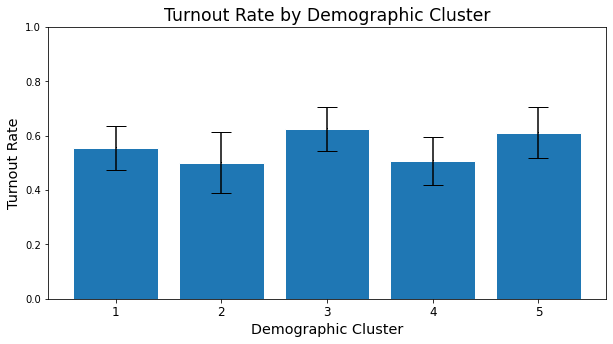

In [56]:
fig = plot_split('cluster', 'turnout', n_bins=False, xlabel='Demographic Cluster')
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/turnout_anova.png', clobber=True)

print_anova('cluster', 'turnout', n_bins=False, target="turnout rate")

### Compare the demographic clusters to the Voter ID Law clusters

#### Compare the clusters using the Fowlkes-Mallows Index

"The [Fowlkes-Mallows Score](https://www.geeksforgeeks.org/ml-fowlkes-mallows-score/) is an evaluation metric to evaluate the similarity among clusterings obtained after applying different clustering algorithms." This value can range from 0, indicating the most dissimilarity between clusterings, to 1, indicating exactly identical clusterings.

In [118]:
idlaws = data_no_ak.dropna().VoterIDLaw

fmi = fowlkes_mallows_score(clust_1.labels_, idlaws)
print('\nFowlkes Mallows Index: {0:.3f}'.format(fmi))


Fowlkes Mallows Index: 0.258


The Fowlkes Mallows index for the demographic clustering vs. the Voter ID law clustering was low, which indicates that these two clusters are not very similar.

#### Compare the clusters using the Dunn Index

The **Dunn Index** is the ratio of the smallest distance between clusters divided by the diameter of the largest cluster. Larger values aremore desirable, as they indicate that the set is composed of small clusters located far apart.

The following implementation of the Dunn Index comes from GitHub user [jqmviegas](https://github.com/jqmviegas/jqm_cvi/blob/master/jqmcvi/base.py).

In [0]:
def delta_fast(ck, cl, distances):
    values = distances[np.where(ck)][:, np.where(cl)]
    values = values[np.nonzero(values)]

    return np.min(values)
    
def big_delta_fast(ci, distances):
    values = distances[np.where(ci)][:, np.where(ci)]
    #values = values[np.nonzero(values)]
            
    return np.max(values)

def dunn_fast(points, labels):
    """ Dunn index - FAST (using sklearn pairwise euclidean_distance function)
    
    Parameters
    ----------
    points : np.array
        np.array([N, p]) of all points
    labels: np.array
        np.array([N]) labels of all points
    """
    distances = euclidean_distances(points)
    ks = np.sort(np.unique(labels))
    
    deltas = np.ones([len(ks), len(ks)])*1000000
    big_deltas = np.zeros([len(ks), 1])
    
    l_range = list(range(0, len(ks)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta_fast((labels == ks[k]), (labels == ks[l]), distances)
        
        big_deltas[k] = big_delta_fast((labels == ks[k]), distances)

    di = np.min(deltas)/np.max(big_deltas)
    return di

In [137]:
dem_dunn = dunn_fast(clust_cnty_st.values.reshape(-1, 1), clust_1.labels_)
idlaw_dunn = dunn_fast(clust_cnty_st.values.reshape(-1, 1), idlaws)
print('\033[1mAdjusted Rand Index\033[0m')
print('Demographic clustering: {0:.3e}'.format(dem_dunn))
print('Voter ID Law clustering: {0:.3e}'.format(idlaw_dunn))
print('Demographic / Voter ID: {0:.3}'.format(dem_dunn / idlaw_dunn))

Adjusted Rand Index
Demographic clustering: 1.959e-07
Voter ID Law clustering: 1.479e-07
Demographic / Voter ID: 1.32


In [135]:
dem_dunn = dunn_fast(target.values.reshape(-1, 1), clust_1.labels_)
idlaw_dunn = dunn_fast(target.values.reshape(-1, 1), idlaws)
print('\033[1mAdjusted Rand Index on Turnout Rates\033[0m')
print('Demographic clustering: {0:.3e}'.format(dem_dunn))
print('Voter ID Law clustering: {0:.3e}'.format(idlaw_dunn))
print('Demographic / Voter ID: {0:.3}'.format(dem_dunn / idlaw_dunn))

Adjusted Rand Index on Turnout Rates
Demographic clustering: 2.839e-08
Voter ID Law clustering: 2.462e-08
Demographic / Voter ID: 1.15


The Dunn Index of the demographic clustering was 32% larger than that of the Voter ID law clustering. When observing the Dunn index of each clustering on the turnout rates of the counties, the demographic clustering also had a higher value (15% larger than the Voter ID law clustering). These statistics support the claim that states were more likely to have turnout rates similar to other counties with the same demographic makeup than they were to have similar turnout rates to outher counties with the same Voter ID law.

## Clustering at the State Level (Furkan)


In [0]:
# Use clust_state_st as the data to cluster on
clust_state_st = feat_states_st.drop(columns=['VoterIDLaw'])
clust_state_st;

## Random Forest (Grace)

In [61]:
# Use X_train, y_train as the training data
# Use X_test, y_test as the test data
X_train
y_train

X_test
y_test

2654   -0.362223
2040    0.316442
185    -0.102746
1650    0.190748
2114   -0.930661
          ...   
147     1.156380
2116   -0.361138
1129    0.688209
1683   -0.747532
2321    0.984859
Name: turnout, Length: 778, dtype: float64

## Stochastic Gradient Descent (Lan)

In [0]:
# -- initialize an SGD regression model
lm = SGDRegressor(verbose=1)

In [65]:
# -- fit the model with the data
lm.fit(X_train.values.reshape(-1, 9), y_train)

-- Epoch 1
Norm: 0.48, NNZs: 9, Bias: 0.024393, T: 2332, Avg. loss: 0.299552
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.44, NNZs: 9, Bias: 0.003382, T: 4664, Avg. loss: 0.290608
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.50, NNZs: 9, Bias: -0.008054, T: 6996, Avg. loss: 0.291050
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.49, NNZs: 9, Bias: -0.006002, T: 9328, Avg. loss: 0.290631
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.48, NNZs: 9, Bias: 0.000457, T: 11660, Avg. loss: 0.290340
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.45, NNZs: 9, Bias: -0.007600, T: 13992, Avg. loss: 0.290332
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.48, NNZs: 9, Bias: -0.013990, T: 16324, Avg. loss: 0.290685
Total training time: 0.01 seconds.
Convergence after 7 epochs took 0.01 seconds


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=1,
             warm_start=False)

In [0]:
# -- "predict" the training data
model_raw_train = lm.predict(X_train.values.reshape(-1, 9))

# -- unstandardize the model
model_unst_train = model_raw_train * target.std() + target.mean()

# -- unstandardize the train data
raw_train = y_train * target.std() + target.mean()

In [0]:
# -- "predict" the test data
model_raw_test = lm.predict(X_test.values.reshape(-1, 9))

# -- unstandardize the model
model_unst_test = model_raw_test* target.std() + target.mean()

# -- unstandardize the train data
raw_test = y_test * target.std() + target.mean()

In [78]:
# -- calculate MSE of model train
mse_train = ((model_unst_train - raw_train)**2).mean()
print('Mean Squared Error of model fit by train data', "{:.4f}".format(mse_train))

# -- calculate MSE of model test
mse_test = ((model_unst_test - raw_test)**2).mean()
print('Mean Squared Error of model fit by test data', "{:.4}".format(mse_test))

Mean Squared Error of model fit by train data 0.0054
Mean Squared Error of model fit by test data 0.005629


In [69]:
# -- compare with the original variance of the data
raw_train.var(ddof=0)
print('original variance of train data', "{:.7f}".format(raw_train.var(ddof=0)))

original variance of train data 0.0093077


In [70]:
# -- compare with the original variance of the data
raw_test.var(ddof=0)
print('original variance of test data', "{:.7f}".format(raw_test.var(ddof=0)))

original variance of test data 0.0096103


In [71]:
# -- calculate r2 of model train
ssres = ((raw_train - model_unst_train)**2).sum()
sstot = ((raw_train - raw_train.mean())**2).sum()
r2_train = 1.0 - ssres / sstot
print('R Squared of model fit by train data', "{:.4f}".format(r2_train))



# -- calculate R2 of model test
ssres_te = ((raw_test - model_unst_test)**2).sum()
sstot_te = ((raw_test - raw_test.mean())**2).sum()
r2_test = 1.0 - ssres_te / sstot_te
print('R Squared of model fit by test data', "{:.4f}".format(r2_test))

R Squared of model fit by train data 0.4191
R Squared of model fit by test data 0.4142


In [72]:
ssres

12.609589860319016

In [73]:
ssres_te

4.379596981424351

In [0]:
from sklearn.metrics import r2_score

In [86]:
r2_score(raw_train, model_unst_train), r2_score(raw_test, model_unst_test)

(0.41905955195541356, 0.41424505372154297)